In [1]:
mp_20_datasets = {
    "WyFormer": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyForDiffCSP++": ("WyckoffTransformer", "DiffCSP++", "CHGNet_fix"),
    "DiffCSP": ("DiffCSP", "CHGNet_fix")
}
mp_20_biternary_datasets = {
    "WyFormer": ("WyckoffTransformer",),
    "WyFormer+": ("WyckoffTransformer", "CrySPR", "CHGNet_fix"),
    "WyCryst": ('WyCryst', 'CHGNet_fix')
}

In [2]:
from evaluation.generated_dataset import GeneratedDataset, load_all_from_config
mp_20_data = load_all_from_config(
    datasets=list(mp_20_datasets.values()) + \
        [("split", "train"), ("split", "val"), ("split", "test"), ("WyckoffTransformer", "CrySPR", "CHGNet_fix")],
    dataset_name="mp_20")

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [3]:
mp_20_biternary_data = load_all_from_config(
    datasets=list(mp_20_biternary_datasets.values()) + \
        [("split", "train"), ("split", "val"), ("split", "test")],
    dataset_name="mp_20_biternary")

In [4]:
import pandas as pd
from tqdm.auto import tqdm
from evaluation.novelty import NoveltyFilter, filter_by_unique_structure

novelty_reference = pd.concat([
    mp_20_data[('split', 'train')].data,
    mp_20_data[('split', 'val')].data], axis=0, verify_integrity=True)
novelty_filter = NoveltyFilter(novelty_reference)

In [5]:
(mp_20_data[('split', 'test')].data.group == 1).mean()

0.018129560026531065

In [6]:
(mp_20_biternary_data[('split', 'test')].data.group == 1).mean()

0.011098623208766508

In [7]:
from evaluation.statistical_evaluator import StatisticalEvaluator

In [8]:
evaluator = StatisticalEvaluator(mp_20_data[('split', 'test')].data)
table = pd.DataFrame(
    index=mp_20_datasets.keys(), columns=[
        "Novelty (%)", "Charge neutrality (%)",
        "Num sites KS", "Num elements KS",
        "DoF KS", "P1 (%)", "SG chi2", "Elements chi2",
        "S.U.N. (%)"])
table.index.name = "Method"
E_hull_threshold = 0.08
element_counts = {}
novel_ehull = {}
for name, transformations in tqdm(mp_20_datasets.items()):
    dataset = mp_20_data[transformations]
    unique = filter_by_unique_structure(dataset.data)
    print(f"Unique: {len(unique)} / {len(dataset.data)} = {len(unique) / len(dataset.data)}")
    novel = novelty_filter.get_novel(unique)
    table.loc[name, "Novelty (%)"] = 100 * len(novel) / len(unique)
    table.loc[name, "Charge neutrality (%)"] = 100 * novel.smact_validity.mean()
    table.loc[name, "Num sites KS"] = evaluator.get_num_sites_ks(novel).statistic
    table.loc[name, "Num elements KS"] = evaluator.get_num_elements_ks(novel).statistic
    table.loc[name, "DoF KS"] = evaluator.get_dof_ks(novel).statistic
    table.loc[name, "P1 (%)"] = 100 * (novel.group == 1).mean()
    table.loc[name, "SG chi2"] = evaluator.get_sg_chi2(novel)
    table.loc[name, "Elements chi2"], element_counts[name] = \
        evaluator.get_elements_chi2(novel, return_counts=True)
    is_sun = (novel.corrected_chgnet_ehull <= E_hull_threshold)
    has_ehull = dataset.data.corrected_chgnet_ehull.notna().sum()
    table.loc[name, "S.U.N. (%)"] = 100 * is_sun.sum() / has_ehull
    novel_ehull[name] = novel.corrected_chgnet_ehull
table

  0%|          | 0/3 [00:00<?, ?it/s]

Unique: 1000 / 1000 = 1.0
Unique: 1000 / 1000 = 1.0
Unique: 996 / 1000 = 0.996


,Novelty (%),Charge neutrality (%),Num sites KS,Num elements KS,DoF KS,P1 (%),SG chi2,Elements chi2,S.U.N. (%)
Method,,,,,,,,,
WyFormer,90.0,80.444444,0.057557,0.054826,0.066433,3.333333,0.221954,0.039941,39.239239
WyForDiffCSP++,89.5,80.335196,0.04644,0.055162,0.040195,1.452514,0.211374,0.039068,36.7
DiffCSP,90.060241,80.936455,0.415229,0.163834,0.406518,36.566332,7.947035,0.099073,57.4


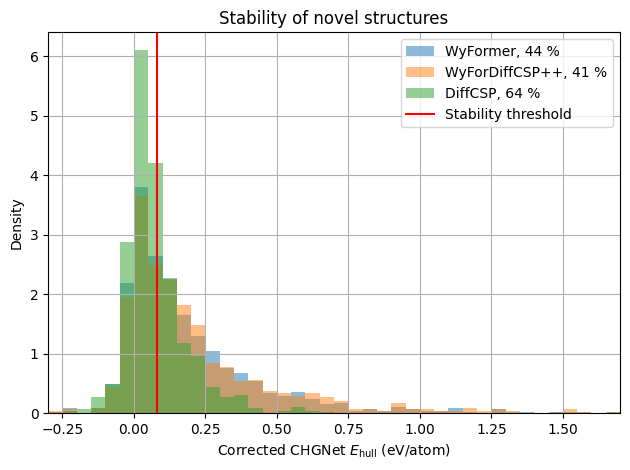

In [9]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bins = np.arange(-0.5, 3, 0.05)
for name, ehull in novel_ehull.items():
    ax.hist(ehull, label=f"{name}, {100*(ehull < E_hull_threshold).mean():.0f} %",
    alpha=0.5, bins=bins, density=True)
ax.set_xlim(-0.3, 1.7)
ax.axvline(E_hull_threshold, color="red", label="Stability threshold")
ax.set_xlabel("Corrected CHGNet $E_\\text{hull}$ (eV/atom)")
ax.set_ylabel("Density")
ax.legend()
ax.grid()
ax.set_title("Stability of novel structures")
fig.tight_layout()
fig.savefig("plots/AI4AM_NeurIPS_2024/DiffCSP_vs_WyckoffTransformer_stability.pdf")

In [10]:
from evaluation.cdvae_metrics import timed_smact_validity_from_record

In [11]:
evaluator = StatisticalEvaluator(mp_20_biternary_data[('split', 'test')].data)
table = pd.DataFrame(
    index=mp_20_biternary_datasets.keys(), columns=[
        "Novelty (%)", "Charge neutrality (%)",
        "Num sites KS", "Num elements KS",
        "DoF KS", "P1 (%)", "SG chi2", "Elements chi2",
        "S.U.N. (%)"])
table.index.name = "Method"
E_hull_threshold = 0.08
novel_ehull = {}
for name, transformations in tqdm(mp_20_biternary_datasets.items()):
    dataset = mp_20_biternary_data[transformations]
    unique = filter_by_unique_structure(dataset.data)
    print(f"Unique: {len(unique)} / {len(dataset.data)} = {len(unique) / len(dataset.data)}")
    novel = novelty_filter.get_novel(unique)
    table.loc[name, "Novelty (%)"] = 100 * len(novel) / len(unique)
    if "smact_validity" in novel.columns:
        table.loc[name, "Charge neutrality (%)"] = 100 * novel.smact_validity.mean()
    else:
        table.loc[name, "Charge neutrality (%)"] = 100 * novel.apply(
            timed_smact_validity_from_record, axis=1).mean()
    table.loc[name, "Num sites KS"] = evaluator.get_num_sites_ks(novel).statistic
    table.loc[name, "Num elements KS"] = evaluator.get_num_elements_ks(novel).statistic
    table.loc[name, "DoF KS"] = evaluator.get_dof_ks(novel).statistic
    table.loc[name, "P1 (%)"] = 100 * (novel.group == 1).mean()
    table.loc[name, "SG chi2"] = evaluator.get_sg_chi2(novel)
    table.loc[name, "Elements chi2"] = evaluator.get_elements_chi2(novel)
    is_sun = (novel.corrected_chgnet_ehull <= E_hull_threshold)
    has_ehull = dataset.data.corrected_chgnet_ehull.notna().sum()
    table.loc[name, "S.U.N. (%)"] = 100 * is_sun.sum() / has_ehull
    novel_ehull[name] = novel.corrected_chgnet_ehull.dropna()
table

  0%|          | 0/3 [00:00<?, ?it/s]

Unique: 9822 / 10000 = 0.9822
Unique: 999 / 999 = 1.0
Unique: 994 / 994 = 1.0


,Novelty (%),Charge neutrality (%),Num sites KS,Num elements KS,DoF KS,P1 (%),SG chi2,Elements chi2,S.U.N. (%)
Method,,,,,,,,,
WyFormer,89.3708,79.254956,0.052273,0.029278,0.055735,1.116427,0.063005,0.018683,38.738739
WyFormer+,91.091091,77.252747,0.0514,0.057391,0.047035,1.428571,0.223784,0.047218,38.438438
WyCryst,52.615694,75.525813,0.2873,0.002406,0.282513,4.780115,0.824438,0.13974,36.720322


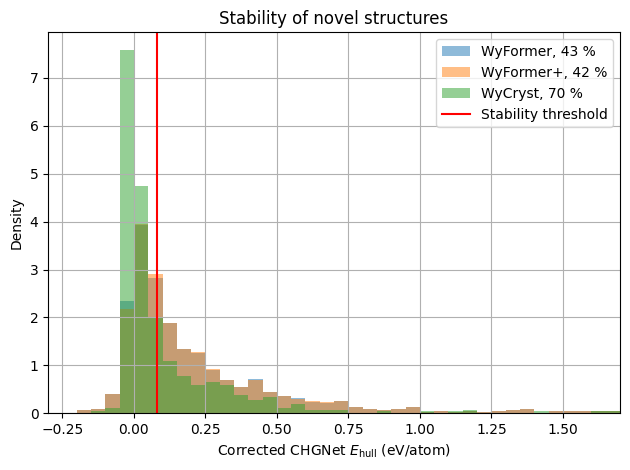

In [12]:
import numpy as np
fig, ax = plt.subplots()
bins = np.arange(-0.5, 3, 0.05)
for name, ehull in novel_ehull.items():
    ax.hist(ehull, label=f"{name}, {100*(ehull < E_hull_threshold).mean():.0f} %",
    alpha=0.5, bins=bins, density=True)
ax.set_xlim(-0.3, 1.7)
ax.axvline(E_hull_threshold, color="red", label="Stability threshold")
ax.set_xlabel("Corrected CHGNet $E_\\text{hull}$ (eV/atom)")
ax.set_ylabel("Density")
ax.legend()
ax.grid()
ax.set_title("Stability of novel structures")
fig.tight_layout()
fig.savefig("plots/AI4AM_NeurIPS_2024/WyCryst_vs_WyckoffTransformer_stability.pdf")